Home Points, Away Points, Pace, Pythag Correlations
0.34264058722466467
0.3157166631740214
0.404605421387391
0.38843758456423605


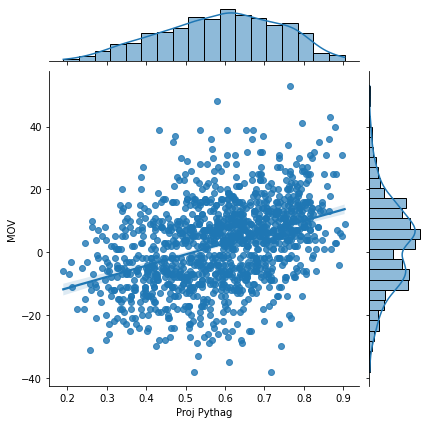

In [33]:
#@title This cell initializes the gamma prediction model

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.metrics import r2_score
from scipy.stats import gamma
from sklearn.neighbors import NearestNeighbors
import seaborn as sns
from datetime import datetime

# TODO
# adjust how atk and def ratings are calculated
# right now, they weight each game equally
# which overweights the possessions in high possession games

# NOTE
# gamma regressor may not be optimal for this projection
# use this to experiment with Keras/TensorFlow

game_data = pd.read_csv('/content/drive/MyDrive/Sports Data Analysis/NBA/Combined-Data.csv').dropna().reset_index(drop=True)

# Build sample/test datasets to perform repeated tests
# For example, sample goes through 2016 season, test 2017 season
# then reset sample to go through 2017, and test 2018 season
# That is the best way to leverage the massive quantity of data available

sample_data = game_data[game_data['Season'] < 2015]
test_data = game_data[game_data['Season'] == 2015].reset_index(drop=True)

# Create sample datasets to train model

sample_home = [[sample_data['Home Atk'][x], sample_data['Away Def'][x]] for x in range(len(sample_data))]
sample_away = [[sample_data['Away Atk'][x], sample_data['Home Def'][x]] for x in range(len(sample_data))]
sample_pace = [[sample_data['Home Pace'][x], sample_data['Away Pace'][x]] for x in range(len(sample_data))]

# Initialize a gamma linear distribution model

gld_home = linear_model.TweedieRegressor(power=2, alpha=0.0, link='log', warm_start=False)
gld_away = linear_model.TweedieRegressor(power=2, alpha=0.0, link='log', warm_start=False)
gld_pace = linear_model.TweedieRegressor(power=2, alpha=0.0, link='log', warm_start=False)

# Fit the model based on the sample data

gld_home.fit(sample_home, np.array(sample_data['Home Eff']))
gld_away.fit(sample_away, np.array(sample_data['Away Eff']))
gld_pace.fit(sample_pace, np.array(sample_data['Pace']))

# Create test datasets

pred_home = [[test_data['Home Atk'][x], test_data['Away Def'][x]] for x in range(len(test_data))]
pred_away = [[test_data['Away Atk'][x], test_data['Home Def'][x]] for x in range(len(test_data))]
pred_pace = [[test_data['Home Pace'][x], test_data['Away Pace'][x]] for x in range(len(test_data))]

# Use the model to predict outcomes in the test data

model_home_eff = gld_home.predict(pred_home)
model_away_eff = gld_away.predict(pred_away)
model_pace = gld_pace.predict(pred_pace)

test_data['Proj Pace'] = np.array(model_pace)
test_data['Proj Home Eff'] = np.array(model_home_eff)
test_data['Proj Home Points'] = np.multiply(test_data['Proj Home Eff'], test_data['Proj Pace'])
test_data['Proj Away Eff'] = np.array(model_away_eff)
test_data['Proj Away Points'] = np.multiply(test_data['Proj Away Eff'], test_data['Proj Pace'])
test_data['Proj Pythag'] = np.divide(np.power(model_home_eff, 16.5),
                                     np.add(np.power(model_home_eff, 16.5), np.power(model_away_eff, 16.5)))

print('Home Points, Away Points, Pace, Pythag Correlations')
print(test_data['Home Points'].corr(test_data['Proj Home Points']))
print(test_data['Away Points'].corr(test_data['Proj Away Points']))
print(test_data['Proj Pace'].corr(test_data['Pace']))
print(test_data['Proj Pythag'].corr(test_data['MOV']))


sns.jointplot(data=test_data, x='Proj Pythag', y='MOV', kind='reg')

In [28]:
def CalcBet(df, x):
    threshold = .15
    max_edge = max(df['Home Edge'].iloc[x], df['Away Edge'].iloc[x])
    if max_edge < threshold:
        return 'No Bet'
    elif max_edge == df['Home Edge'].iloc[x]:
        return 'H'
    else:
        return 'A'
    
def CalcProfit(df, x):
    if df['Model Bet'].iloc[x] == 'No Bet':
        return 0
    if df['Model Bet'].iloc[x] == 'H':
        if df['MOV'].iloc[x] > 0:
          return (1/df['Home Implied Prob'].iloc[x] - 1)
        else:
          return -1
    else:
        if df['MOV'].iloc[x] < 0:
          return (1/df['Away Implied Prob'].iloc[x] - 1)
        else:
          return -1

test_data['Home Edge'] = np.subtract(test_data['Proj Pythag'], test_data['Home Implied Prob'])
test_data['Away Edge'] = np.subtract(np.subtract(1, test_data['Proj Pythag']), test_data['Away Implied Prob'])
test_data['Model Bet'] = [CalcBet(test_data, x) for x in range(len(test_data))]
test_data['Profit'] = [CalcProfit(test_data, x) for x in range(len(test_data))]

print('Total Profit: ', test_data['Profit'].sum(), ' on ', len(test_data[test_data['Model Bet'] != 'No Bet']), ' total bets')
print(test_data.loc[test_data['Model Bet'] == 'H', ['Profit']].sum(), ' on ', len(test_data[test_data['Model Bet'] == 'H']), ' H bets')
print(test_data.loc[test_data['Model Bet'] == 'A', ['Profit']].sum(), ' on ', len(test_data[test_data['Model Bet'] == 'A']), ' A bets')
print(len(test_data), ' games in the test set')

print(' ')
print(len(test_data[test_data['MOV'] > 0]) / len(test_data), ': home win percentage')
print(test_data['Proj Pythag'].mean(), ': average projected pythagorean expectation')
print(test_data['Pythag'].mean(), ': average actual pythagorean expectation')


Total Profit:  -10.799999999999983  on  240  total bets
Profit   -4.45
dtype: float64  on  140  H bets
Profit   -6.35
dtype: float64  on  100  A bets
1229  games in the test set
 
0.5752644426362896 : home win percentage
0.5879271028535462 : average projected pythagorean expectation
0.5573439450914653 : average actual pythagorean expectation
